In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from src.utils.utils import add_spatial_encoding

In [2]:
MARGIN_MIN = 7
MIN_INIT_VELOCITY = 1000.
WIDTH, HEIGHT = 28, 28
RADIUS = 3
size = WIDTH

print("-"*50)
print("Generating images...")
images = np.load("data/movingmnist_dataset_10000_20_1_28_2/sequences.npy").swapaxes(-1, -2)
# Apply the sigmoid function to the images
# images = np.exp(3*images) / (1 + np.exp(3*images)) - 0.5
images = (images - images.min()) / (images.max() - images.min())
# images = np.load("data/mnist_test_seq_resized.npy").swapaxes(0,1)
print(images.shape, images.max(), images.min())
shape = images.shape

images = images.reshape(-1, 1, shape[-2], shape[-1])
print(images.shape)
N = shape[0]
N_frames = shape[1]
dt = 1./N_frames
Num_pos_velocity = 1
times = np.arange(0, N_frames*dt, dt)

# dataset = [(image, 0) for image in dataset]
# dataset = add_spatial_encoding(dataset)
# print(len(dataset), len(dataset[0]), dataset[0][0].shape)
images = torch.from_numpy(add_spatial_encoding(images)).float().reshape(N, -1, 3, HEIGHT, WIDTH)

# split the dataset
images_train, images_test = train_test_split(images, test_size=0.2, random_state=42)

print(images_train.shape, images_test.shape)

--------------------------------------------------
Generating images...
(10000, 20, 28, 28) 1.0 0.0
(200000, 1, 28, 28)
torch.Size([8000, 20, 3, 28, 28]) torch.Size([2000, 20, 3, 28, 28])


In [31]:
class PSNR:
    """Peak Signal to Noise Ratio
    img1 and img2 have range [0, 1]"""

    def __init__(self):
        self.name = "PSNR"
        self._value = 0.0
        self._num_examples = 0

    
    def update(self, img1, img2):
        if img1.shape != img2.shape:
            raise ValueError("Input images must have the same dimensions but got %s and %s" % (str(img1.shape), str(img2.shape)))
        
        if img1.ndim !=4 and img1.ndim != 5:
            raise ValueError("Input images must have 4 or 5 dimensions but got {}".format(img1.ndim))
            
        if img1.ndim == 5 and img2.ndim == 5:
            img1 = img1.view(-1, *img1.shape[2:])
            img2 = img2.view(-1, *img2.shape[2:])
        
        mse = torch.mean((img1 - img2)**2, dim=(1, 2, 3))

        self._value += 10 * torch.log10(1. / mse).sum()
        self._num_examples += img1.shape[0]

    def reset(self):
        self._value = 0.0
        self._num_examples = 0


    def compute(self):
        if self._num_examples == 0:
            raise ValueError("SSIM must have at least one example before it can be computed.")
        return self._value / self._num_examples


In [32]:
from typing import Union, Sequence, Callable

class SSIM(nn.Module):
    """
    Computes Structual Similarity Index Measure
    Args:
        data_range: Range of the image. Typically, ``1.0`` or ``255``.
        kernel_size: Size of the kernel. Default: (11, 11)
        sigma: Standard deviation of the gaussian kernel.
            Argument is used if ``gaussian=True``. Default: (1.5, 1.5)
        k1: Parameter of SSIM. Default: 0.01
        k2: Parameter of SSIM. Default: 0.03
        gaussian: ``True`` to use gaussian kernel, ``False`` to use uniform kernel
        output_transform: A callable that is used to transform the
            :class:`~ignite.engine.engine.Engine`'s ``process_function``'s output into the
            form expected by the metric.
        device: specifies which device updates are accumulated on. Setting the metric's
            device to be the same as your ``update`` arguments ensures the ``update`` method is non-blocking. By
            default, CPU.
    Examples:
        To use with ``Engine`` and ``process_function``, simply attach the metric instance to the engine.
        The output of the engine's ``process_function`` needs to be in the format of
        ``(y_pred, y)`` or ``{'y_pred': y_pred, 'y': y, ...}``.
        ``y_pred`` and ``y`` can be un-normalized or normalized image tensors. Depending on that, the user might need
        to adjust ``data_range``. ``y_pred`` and ``y`` should have the same shape.
        For more information on how metric works with :class:`~ignite.engine.engine.Engine`, visit :ref:`attach-engine`.
        .. include:: defaults.rst
            :start-after: :orphan:
        .. testcode::
            metric = SSIM(data_range=1.0)
            metric.attach(default_evaluator, 'ssim')
            preds = torch.rand([4, 3, 16, 16])
            target = preds * 0.75
            state = default_evaluator.run([[preds, target]])
            print(state.metrics['ssim'])
        .. testoutput::
            0.9218971...
    .. versionadded:: 0.4.2
    """

    def __init__(
        self,
        data_range: Union[int, float],
        kernel_size: Union[int, Sequence[int]] = (11, 11),
        sigma: Union[float, Sequence[float]] = (1.5, 1.5),
        k1: float = 0.01,
        k2: float = 0.03,
        gaussian: bool = True,
        output_transform: Callable = lambda x: x,
        device: Union[str, torch.device] = torch.device("cpu"),
    ):
        if isinstance(kernel_size, int):
            self.kernel_size = [kernel_size, kernel_size]  # type: Sequence[int]
        elif isinstance(kernel_size, Sequence):
            self.kernel_size = kernel_size
        else:
            raise ValueError("Argument kernel_size should be either int or a sequence of int.")

        if isinstance(sigma, float):
            self.sigma = [sigma, sigma]  # type: Sequence[float]
        elif isinstance(sigma, Sequence):
            self.sigma = sigma
        else:
            raise ValueError("Argument sigma should be either float or a sequence of float.")

        if any(x % 2 == 0 or x <= 0 for x in self.kernel_size):
            raise ValueError(f"Expected kernel_size to have odd positive number. Got {kernel_size}.")

        if any(y <= 0 for y in self.sigma):
            raise ValueError(f"Expected sigma to have positive number. Got {sigma}.")

        super(SSIM, self).__init__()
        self._device = device
        self._output_transform = output_transform
        self.gaussian = gaussian
        self.c1 = (k1 * data_range) ** 2
        self.c2 = (k2 * data_range) ** 2
        self.pad_h = (self.kernel_size[0] - 1) // 2
        self.pad_w = (self.kernel_size[1] - 1) // 2
        self._kernel = self._gaussian_or_uniform_kernel(kernel_size=self.kernel_size, sigma=self.sigma)
        self.reset()
        

    def reset(self) -> None:
        self._sum_of_ssim = torch.tensor(0.0, dtype=torch.float64, device=self._device)
        self._num_examples = 0
        self._kernel = self._gaussian_or_uniform_kernel(kernel_size=self.kernel_size, sigma=self.sigma)

    def _uniform(self, kernel_size: int) -> torch.Tensor:
        max, min = 2.5, -2.5
        ksize_half = (kernel_size - 1) * 0.5
        kernel = torch.linspace(-ksize_half, ksize_half, steps=kernel_size, device=self._device)
        for i, j in enumerate(kernel):
            if min <= j <= max:
                kernel[i] = 1 / (max - min)
            else:
                kernel[i] = 0

        return kernel.unsqueeze(dim=0)  # (1, kernel_size)

    def _gaussian(self, kernel_size: int, sigma: float) -> torch.Tensor:
        ksize_half = (kernel_size - 1) * 0.5
        kernel = torch.linspace(-ksize_half, ksize_half, steps=kernel_size, device=self._device)
        gauss = torch.exp(-0.5 * (kernel / sigma).pow(2))
        return (gauss / gauss.sum()).unsqueeze(dim=0)  # (1, kernel_size)

    def _gaussian_or_uniform_kernel(self, kernel_size: Sequence[int], sigma: Sequence[float]) -> torch.Tensor:
        if self.gaussian:
            kernel_x = self._gaussian(kernel_size[0], sigma[0])
            kernel_y = self._gaussian(kernel_size[1], sigma[1])
        else:
            kernel_x = self._uniform(kernel_size[0])
            kernel_y = self._uniform(kernel_size[1])

        return torch.matmul(kernel_x.t(), kernel_y)  # (kernel_size, 1) * (1, kernel_size)

    def update(self, y_pred, y) -> None:
        y_pred, y = y_pred.detach(), y.detach()

        if y_pred.dtype != y.dtype:
            raise TypeError(
                f"Expected y_pred and y to have the same data type. Got y_pred: {y_pred.dtype} and y: {y.dtype}."
            )

        if y_pred.shape != y.shape:
            raise ValueError(
                f"Expected y_pred and y to have the same shape. Got y_pred: {y_pred.shape} and y: {y.shape}."
            )

        if len(y_pred.shape) == 5 and len(y.shape) == 5:
            y_pred = y_pred.view(-1, *y_pred.shape[2:])
            y = y.view(-1, *y.shape[2:])
            
        if len(y_pred.shape) != 4 or len(y.shape) != 4:
            raise ValueError(
                f"Expected y_pred and y to have BxCxHxW shape. Got y_pred: {y_pred.shape} and y: {y.shape}."
            )

        channel = y_pred.size(1)
        if len(self._kernel.shape) < 4:
            self._kernel = self._kernel.expand(channel, 1, -1, -1).to(device=y_pred.device)

        y_pred = F.pad(y_pred, [self.pad_w, self.pad_w, self.pad_h, self.pad_h], mode="reflect")
        y = F.pad(y, [self.pad_w, self.pad_w, self.pad_h, self.pad_h], mode="reflect")

        input_list = torch.cat([y_pred, y, y_pred * y_pred, y * y, y_pred * y])
        outputs = F.conv2d(input_list, self._kernel, groups=channel)

        output_list = [outputs[x * y_pred.size(0) : (x + 1) * y_pred.size(0)] for x in range(len(outputs))]

        mu_pred_sq = output_list[0].pow(2)
        mu_target_sq = output_list[1].pow(2)
        mu_pred_target = output_list[0] * output_list[1]

        sigma_pred_sq = output_list[2] - mu_pred_sq
        sigma_target_sq = output_list[3] - mu_target_sq
        sigma_pred_target = output_list[4] - mu_pred_target

        a1 = 2 * mu_pred_target + self.c1
        a2 = 2 * sigma_pred_target + self.c2
        b1 = mu_pred_sq + mu_target_sq + self.c1
        b2 = sigma_pred_sq + sigma_target_sq + self.c2

        ssim_idx = (a1 * a2) / (b1 * b2)
        self._sum_of_ssim += torch.mean(ssim_idx, (1, 2, 3), dtype=torch.float64).sum().to(self._device)

        self._num_examples += y.shape[0]

        

    def compute(self) -> float:
        if self._num_examples == 0:
            raise ValueError("SSIM must have at least one example before it can be computed.")
        return (self._sum_of_ssim / self._num_examples).item()

In [33]:
psnr = PSNR()
ssim = SSIM(data_range=1.0)

In [39]:
preds = torch.rand([4, 3, 16, 16])
target = preds * 0.75
psnr.update(preds, target)
print(psnr.compute())
psnr.reset()

tensor(16.7956)


In [35]:
trajectory = images[:, 0, 0, :, :].unsqueeze(1)
print(trajectory.shape)
trajectory2 = images[:, 4, 0, :, :].unsqueeze(1)
print(trajectory2.shape)
ssim.update(trajectory, trajectory2)
print(ssim.compute())
ssim.reset()

# trajectory = images[:, :, 0, :, :].unsqueeze(2)
# print(trajectory.shape)
# trajectory2 = images[:, :, 0, :, :].unsqueeze(2)
# print(trajectory2.shape)
# print(ssim(trajectory, trajectory2))

for i in range(10):
    trajectory = images[i, :, 0, :, :].unsqueeze(1)
    trajectory2 = images[i+1, :, 0, :, :].unsqueeze(1)
    psnr.update(trajectory, trajectory2)
    ssim.update(trajectory, trajectory2)

print(psnr.compute(), ssim.compute())
psnr.reset()
ssim.reset()

trajectory = images[:10, :, 0, :, :].unsqueeze(2)
trajectory2 = images[1:11, :, 0, :, :].unsqueeze(2)
psnr.update(trajectory, trajectory2)
ssim.update(trajectory, trajectory2)
print(psnr.compute(), ssim.compute())
psnr.reset()
ssim.reset()


torch.Size([10000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])
0.6637754018690903
tensor(14.2807) 0.6400145810351162
tensor(14.2807) 0.6400145810351161


In [29]:
psnr = ignite.metrics.PSNR(data_range=1.)
ssim = ignite.metrics.SSIM(data_range=1.0)

NameError: name 'ignite' is not defined

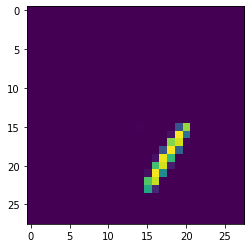

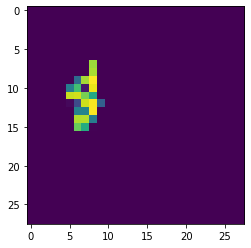

In [18]:
shift = 5
test_input = images_test[0, :, :, :, :]
test_target = images_test[shift, :, :, :, :]

index = 0
plt.imshow(test_input[index, 0].numpy())
plt.show()
plt.imshow(test_target[index, 0].numpy())
plt.show()

In [ ]:
# First test between 2 diff trajectories
ssim.attach(default_evaluator, 'ssim')

In [14]:
# evaluate ssim and psnr
psnr.reset()
ssim.reset()
psnr.update((test_input[index, 0].unsqueeze(1), test_target[index, 0].unsqueeze(1)))
ssim.update((test_input[index, 0], test_target[index, 0]))
print("PSNR:", psnr.compute())
print("SSIM:", ssim.compute())


ValueError: Expected y_pred and y to have BxCxHxW shape. Got y_pred: torch.Size([28, 28]) and y: torch.Size([28, 28]).